<a href="https://colab.research.google.com/github/Onmang/Multimedia_engineering/blob/master/t20me022_0721.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.10.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 42.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!pip install mecab-python3
!pip install unidic-lite

  Using cached mecab_python3-1.0.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (581 kB)
  Using cached unidic-lite-1.0.8.tar.gz (47.4 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for unidic-lite: filename=unidic_lite-1.0.8-py3-none-any.whl size=47658818 sha256=51d3fce616cac82d43a134c01885b201181c6371505554e8f52a56e98dc2cf2d
  Stored in directory: /root/.cache/pip/wheels/89/e8/68/f9ac36b8cc6c8b3c96888cd57434abed96595d444f42243853
Successfully built unidic-lite


In [2]:
import pandas
import numpy as np
import MeCab

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import StringLookup, TimeDistributed, Embedding
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Bidirectional, Masking
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy



In [3]:
jp_vocab = set() # Initialize Japanese vocabulary set
en_vocab = set() # Initialize English vocabulary set
jp_sents = [] # For Japanese sentences
en_sents = [] # For English sentences
wakati = MeCab.Tagger('-Owakati')  #Mecab。分かち書きオプションを利用
# Function for saving data to a file
def save_text(file, sents):
  with open(file, 'w', encoding='utf-8') as f:
     for s in sents:
      f.write( ' '.join(s) )
      f.write('\\n')

 # open Excel file
df = pandas.read_excel('/content/drive/MyDrive/JEC_basic_sentence_v1-3.xls', sheet_name=0)
# Process sentence-by-sentence
for i, d in enumerate(df.values):
  jp = d[1] # Getting Chinese sentence
  en = d[2].replace('.', '').replace('\"','') # Getting English sentence and remove period and \" marks
  # For Japanese
  jp_words = wakati.parse(jp).strip().split() # 形態素解析を実行
  jp_vocab.update(jp_words) # 日本語の語彙集合を更新
  jp_sents.append(jp_words) # 日本語をリストに保存
  # For English
  en_words = en.split() # Segment to Engish words
  en_vocab.update(en_words) # update vocabulary for English
  en_sents.append(en_words)
# Save sentence to text file
save_text('jp_sentence.txt', jp_sents) # Save Chinese sentences to a file
save_text('en_sentence.txt', en_sents) # Save English sentences to a file
# Japanese
jp_vocab = sorted(jp_vocab)
jp_vocab.insert(0, 'MASK') # For Mask word (zero-padding)
jp_vocab.insert(1, '<start>') # Start symbol
jp_vocab.insert(2, '<end>') # end of sentence
# English
en_vocab = sorted(en_vocab)
en_vocab.insert(0, 'MASK')
en_vocab.insert(1, '<start>')
en_vocab.insert(2, '<end>')

jp_vocab_size = len(jp_vocab) + 1 # unknown (unk)
jp_char_to_num = StringLookup(vocabulary=jp_vocab, oov_token='<unk>')
jp_num_to_char = StringLookup(vocabulary=jp_char_to_num.get_vocabulary(), oov_token='<unk>', invert=True)
# jvocab = [w.encode('utf-8') for w in jvocab] # バイナリに変換しておく
en_vocab_size = len(en_vocab) + 1
en_char_to_num = StringLookup(vocabulary=en_vocab, oov_token='<unk>')
en_num_to_char = StringLookup(vocabulary=en_char_to_num.get_vocabulary(), oov_token='<unk>', invert=True)
# en_vocab = [w.encode('utf-8') for w in evocab] # バイナリに変換しておく

# Check for Chinese vocabulary set
print(
    f'The vocabulary set is: {jp_char_to_num.get_vocabulary()}'
    f' (size={jp_char_to_num.vocabulary_size()})'
)
print(
    f'The vocabulary set is: {en_char_to_num.get_vocabulary()}'
    f' (size={en_char_to_num.vocabulary_size()})'
)




The vocabulary set is: ['<unk>', 'MASK', '<start>', '<end>', 'X', '¥', '—', '℃', '−', '○', '、', '。', '〜', 'あいさつ', 'あいだ', 'あいつ', 'あいまい', 'あう', 'あえぎ声', 'あえて', 'あきらか', 'あげ', 'あげる', 'あざ', 'あしらい', 'あそこ', 'あたし', 'あたたか', 'あたり', 'あちこち', 'あっ', 'あっさり', 'あっさり味', 'あと', 'あなた', 'あの', 'あふれる', 'あまり', 'あらかじめ', 'あらためて', 'あらゆる', 'あり', 'ある', 'あれ', 'あれこれ', 'あんまり', 'い', 'いい', 'いう', 'いか', 'いき', 'いきなり', 'いく', 'いけ', 'いじめっ子', 'いずれ', 'いたし', 'いたずら', 'いただい', 'いただく', 'いだい', 'いだき', 'いちいち', 'いちご', 'いち早く', 'いっ', 'いっしょ', 'いっそう', 'いっぱい', 'いつ', 'いびつ', 'いま', 'いまだ', 'いや', 'いよいよ', 'いらっしゃい', 'いる', 'いろいろ', 'いろんな', 'いわ', 'いわゆる', 'うち', 'うどん', 'うる', 'うるおい', 'うろうろ', 'うわさ', 'お', 'おい', 'おいしい', 'おかげ', 'おかしい', 'おかしな', 'おき', 'おじ', 'おっしゃっ', 'おでん', 'おととい', 'おととし', 'おなか', 'おはよう', 'おもいやり', 'おもちゃ', 'おもむろに', 'おやつづくり', 'および', 'おら', 'おり', 'おりおり', 'おれ', 'お前', 'お腹', 'お釈迦', 'か', 'かあ', 'かい', 'かかっ', 'かかり', 'かかる', 'かく', 'かけ', 'かける', 'かごかき', 'かすか', 'かぜ', 'かっこ', 'かつ', 'かつて', 'かな', 'かならず', 'かなり', 'かばん', 'かぶる', 'から', 'かわいい', 'か所', 'か月', 'が', 'が〜', 'がたみ

In [4]:
# Function for make mini-batch for N
def make_padding_data(jp_sents, en_sents):
  jp_in_data = [] # Japanese
  en_in_data = [] # English
  label_data = [] # Label, which means correct word sequences
  # Process for Japanese sentence
  for s in jp_sents:
    s = tf.strings.split(s)
    jp_id = jp_char_to_num(s)
    jp_id = tf.concat([[2], jp_id], 0)
    jp_id = tf.concat([jp_id, [3]], 0)
    jp_in_data.append(jp_id[::-1]) # inverse
  # Process for English sentence
  for s in en_sents:
    s = tf.strings.split(s)
    en_id = en_char_to_num(s)
    en_label_id = en_char_to_num(s)
    en_id = tf.concat([[2], en_id], 0)
    en_label_id = tf.concat([en_label_id, [3]], 0)
    en_in_data.append(en_id)
    label_data.append(en_label_id)
  jp_in_data = pad_sequences(jp_in_data, padding='pre', value=1, dtype=np.int32)
  en_in_data = pad_sequences(en_in_data, padding='post', value=1, dtype=np.int32)
  label_data = pad_sequences(label_data, padding='post', value=1, dtype=np.int32)
  return jp_in_data, en_in_data, label_data # Chinese, English, Target English label
# Load Sentence
batch_size = 20
AUTOTUNE = tf.data.experimental.AUTOTUNE
jp_ds = tf.data.TextLineDataset('jp_sentence.txt') # Using TextLineDataset API for text sentence data
en_ds = tf.data.TextLineDataset('en_sentence.txt')
assert len(list(jp_ds)) == len(list(en_ds)), 'Warning: The number of sentences between Japanese and English is different.'
train_ds = tf.data.Dataset.zip((jp_ds, en_ds))
train_ds = train_ds.shuffle(buffer_size=len(list(jp_ds)))
train_ds = train_ds.repeat(1)
train_ds = train_ds.batch(batch_size, drop_remainder=True)
train_ds = train_ds.map(lambda jp, en: tf.py_function(make_padding_data, [jp, en], Tout=[tf.int32, tf.int32, tf.int32]))
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)



In [ ]:
# Check
next(iter(train_ds))


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 jp_input (InputLayer)       [(None, None)]            0         
                                                                 
 mask1 (Masking)             (None, None)              0         
                                                                 
 jp_embed (Embedding)        (None, None, 200)         1280400   
                                                                 
 encoder_lstm (LSTM)         [(None, 256),             467968    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
Total params: 1,748,368
Trainable params: 1,748,368
Non-trainable params: 0
_________________________________________________________________
Model: "model_3"
________________________________

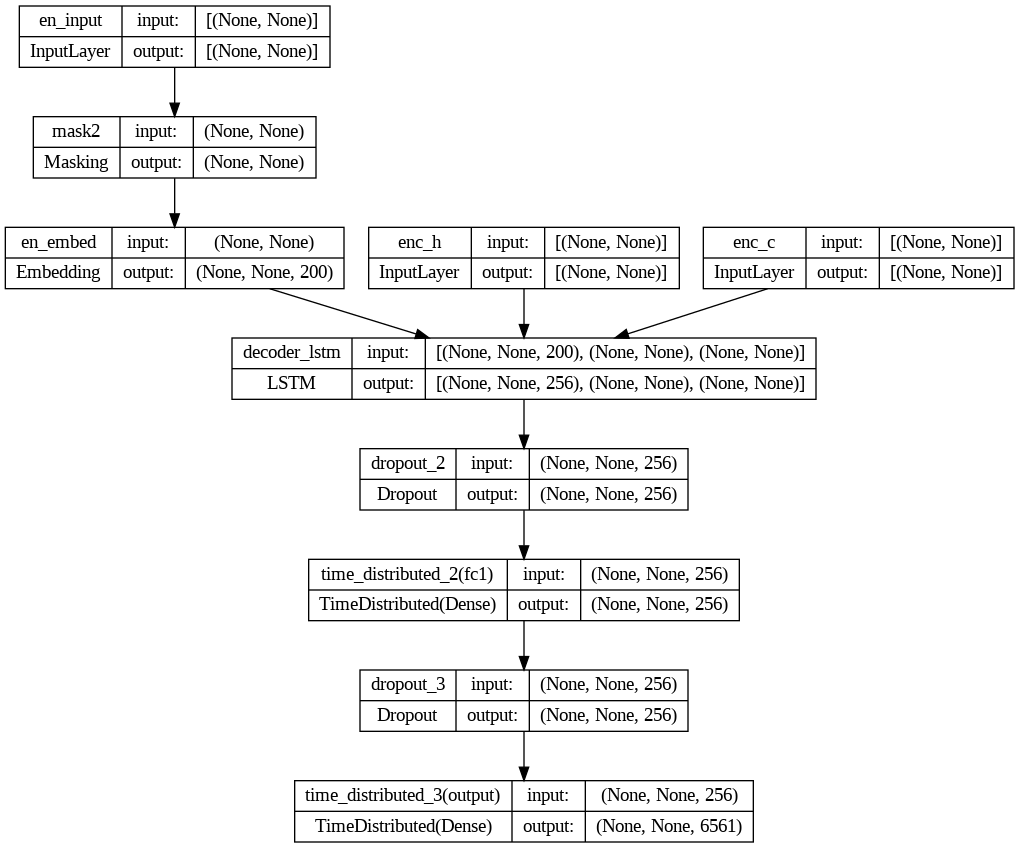

In [7]:
class MT(Model):
  def __init__(self):
      super(MT, self).__init__()
      self.loss_tracker = tf.keras.metrics.Mean(name='loss')
      self.acc_tracker = tf.keras.metrics.SparseCategoricalAccuracy(name='acc')
      self.ce_loss = SparseCategoricalCrossentropy()
      self.encoder = self.encoder_model()
      self.decoder = self.decoder_model()

  def encoder_model(self):
      jp_input = Input(shape=(None,), name='jp_input')
      jp_mask = Masking(mask_value=1, name='mask1')(jp_input)
      jp_embed = Embedding(jp_vocab_size, 200, name='jp_embed')(jp_mask)
      enc_out, enc_h, enc_c = LSTM(256, name='encoder_lstm', return_state=True,
                      kernel_regularizer=l2(0.0001))(jp_embed)
      return Model(inputs=jp_input, outputs=[enc_out, enc_h, enc_c])

  def decoder_model(self):
      en_input = Input(shape=(None,), name='en_input')
      enc_h = Input(shape=(None,), name='enc_h')
      enc_c = Input(shape=(None,), name='enc_c')

      en_mask = Masking(mask_value=1, name='mask2')(en_input) # Mask\n",
      en_embed = Embedding(en_vocab_size, 200, name='en_embed')(en_mask)
      h, dh, dc = LSTM(256, name='decoder_lstm', return_sequences=True, return_state=True,
                                        kernel_regularizer=l2(0.0001))(en_embed, [enc_h, enc_c])
      h = Dropout(0.3)(h)
      h = TimeDistributed(Dense(256, activation='relu',
                                       kernel_regularizer=l2(0.0001), name='fc1'))(h)
      h = Dropout(0.3)(h)
      dec_out = TimeDistributed(Dense(en_vocab_size, activation='softmax', name='output'))(h)
      return Model(inputs=[en_input, enc_h, enc_c], outputs=[dec_out, dh, dc])

  def encoder_decoder(self, ch, en):
      o, h, c = self.encoder([ch])
      preds, h, c = self.decoder([en, h, c])
      return preds, h, c

  @property
  def metrics(self):
      return [self.loss_tracker, self.acc_tracker]

  @tf.function
  def train_step(self, data):
      jp, en, y = data
      self.encoder.reset_states() # Reset before starting training\n",
      self.decoder.reset_states() # Reset before starting training\n",
      with tf.GradientTape() as tape:
        predictions, _, _ = self.encoder_decoder(jp, en)
        loss = self.ce_loss(y, predictions)
      gradients = tape.gradient(loss, self.trainable_variables) # gradient calculation\n",
      self.optimizer.apply_gradients(zip(gradients, self.trainable_variables)) # back propagation\n",
      self.acc_tracker.update_state(y, predictions)
      self.loss_tracker.update_state(loss)
      return {'loss':self.loss_tracker.result(), 'acc':self.acc_tracker.result()}
model = MT()
model.encoder.summary()
model.decoder.summary()
tf.keras.utils.plot_model(model.encoder, show_shapes=True, show_layer_names=True, to_file='mt_encoder.png')

tf.keras.utils.plot_model(model.decoder, show_shapes=True, show_layer_names=True, to_file='mt_decoder.png')



In [8]:
model.compile(optimizer=Adam(0.001))
model.fit(train_ds, initial_epoch=0, epochs=1) # ものすごく時間がかかるので1エポックでよいです。


ValueError: ignored

In [13]:
model.encoder.reset_states()
model.decoder.reset_states()
source = "今日は学校へ行く"

jp_words = wakati.parse(source).strip().split()
jp_id = jp_char_to_num(jp_words)

jp_id = tf.concat([[2], jp_id], 0)
jp_id = tf.concat([jp_id, [3]], 0)
jp_id = jp_id[::-1]
jp_id = tf.expand_dims(jp_id, axis=0)

o, h, c = model.encoder(jp_id)
start = tf.cast([[2]], tf.int32)

pred, h, c = model.decoder([start, h, c])
print('==translation result==')
for i in range(10):
    pred = tf.argmax(pred, axis=2)
    if pred.numpy()[0][0] == 3:
        break
    print(en_num_to_char(pred).numpy()[0][0].decode(), end=' ')
    pred, h, c = model.decoder([pred, h, c])


==translation result==
keywords reaffirmed drink blossomed DSG DSG promenade trading punished trading 